## Setup: 
Fork git repository and clone: https://github.com/gillespielab/gl-spyglass-tables

Setup conda/mamba environment as specified in https://github.com/LorenFrankLab/spyglass/blob/master/environment.yml

In [9]:
import datajoint as dj
import sys
import os

# Alternatively, uncomment these instead of using a dj_local_conf file
# dj.config['database.host'] = "" # enter datajoint host url
# dj.config['database.user'] = "" # enter datajoint username
# dj.config['database.port'] = 3306
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")

from spyglass.common.common_behav import StateScriptFile
from spyglass.common.common_task import TaskEpoch
from spyglass.common.common_nwbfile import AnalysisNwbfile
from spyglass.common.common_session import Session
sys.path.append("..")
from trial_info import TrialInfo

In [7]:
TrialInfo.heading

nwb_file_name        : varchar(64)                  # name of the NWB file
epoch                : int                          # the session epoch for this task and apparatus(1 based)
dio_event_name       : varchar(80)                  # the name assigned to this DIO event
---
analysis_file_name   : varchar(64)                  # name of the file
trial_info_object_id : varchar(40)                  # the NWB object ID for loading this object from the file
parser               : varchar(100)                 # type of parser used to interpret statescript log
descriptors=null     : blob                         # global descriptors for task

In [8]:
TrialInfo()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),dio_event_name the name assigned to this DIO event,analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task
bobrick20231205_.nwb,2,homebeam,bobrick20231205_VBI6MIOPKY.nwb,4589f726-5469-46f3-9158-86ce633dd4e9,V8_delay,=BLOB=
bobrick20231205_.nwb,4,homebeam,bobrick20231205_LWO9Z355MW.nwb,020400eb-09e2-48ed-a9b4-830ecc034f38,V8_delay,=BLOB=


## Inserting epochs:
`TrialInfo.populate()` parses all StateScriptLog run sessions. Here, we we can also insert epochs from a single animal.

In [ ]:
nwb_file_name = "bobrick20231205_.nwb"

In [12]:
TrialInfo.populate(StateScriptFile & {'nwb_file_name' : nwb_file_name})

[09:53:03][INFO] Spyglass: Skipping sleep epoch: bobrick20231201_.nwb, epoch 1


bug trial #0, epoch 2! line 257: index 0 is out of bounds for axis 0 with size 0


[09:53:04][INFO] Spyglass: Writing new NWB file bobrick20231201_4N9UXDG66U.nwb
[09:53:07][INFO] Spyglass: Skipping sleep epoch: bobrick20231201_.nwb, epoch 3
[09:53:08][INFO] Spyglass: Writing new NWB file bobrick20231201_I1E2AV96PN.nwb
[09:53:11][INFO] Spyglass: Skipping sleep epoch: bobrick20231201_.nwb, epoch 5


## Reading the resulting analysis file

In [15]:
# select a specific epoch for the inserted session
restr = {"nwb_file_name": nwb_file_name, "epoch": 2}

In [16]:
# accessing trial descriptors
(TrialInfo & restr).fetch1("descriptors")

{'statescript': 'V8pre_delay_locknoise_uw.sc',
 'lockout_period': 30.0,
 'python_script': 'V8.py',
 'outer_reps': 10,
 'num_goals': 1,
 'forage_num': 1}

In [17]:
# fetching dataframe for the specified run epoch
df = (TrialInfo & restr).fetch1_dataframe()
df

,trial_num,start_time,end_time,leave_home,trial_type,rw_start,rw_end,leave_rw,rw_success,outer_well,goal_well,outer_time,leave_outer,outer_success,lockout_starts,lockout_ends,during_lockout,lockout_type
id,,,,,,,,,,,,,,,,,,
0,1,1.701455e+09,1.701455e+09,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0.0,2.0,0.000000e+00,0.000000e+00,0,[],[],[],0
1,2,1.701455e+09,1.701455e+09,1.701455e+09,1,1.701455e+09,1.701455e+09,1.701455e+09,1,5.0,2.0,1.701455e+09,1.701455e+09,0,[],[],[],0
2,3,1.701455e+09,1.701455e+09,1.701455e+09,1,1.701455e+09,1.701455e+09,1.701455e+09,1,1.0,2.0,1.701455e+09,1.701455e+09,0,[],[],[],0
3,4,1.701455e+09,1.701455e+09,1.701455e+09,2,1.701455e+09,1.701455e+09,1.701455e+09,1,4.0,2.0,1.701455e+09,1.701455e+09,0,[],[],[],0
4,5,1.701455e+09,1.701455e+09,1.701455e+09,1,1.701455e+09,1.701455e+09,1.701455e+09,1,7.0,2.0,1.701455e+09,1.701455e+09,0,[],[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,1.701460e+09,1.701460e+09,1.701460e+09,1,1.701460e+09,1.701460e+09,1.701460e+09,0,0.0,0.0,0.000000e+00,0.000000e+00,0,[1701460165.7764819],[1701460195.7764819],[3],3
108,109,1.701460e+09,1.701460e+09,1.701460e+09,1,1.701460e+09,1.701460e+09,1.701460e+09,1,0.0,0.0,0.000000e+00,0.000000e+00,0,[1701460240.035482],[1701460270.035482],"[3, 5, 1]",1
109,110,1.701460e+09,1.701460e+09,1.701460e+09,1,1.701460e+09,1.701460e+09,1.701460e+09,1,0.0,0.0,0.000000e+00,0.000000e+00,0,[1701460342.778482],[1701460372.778482],"[2, 9, 1]",1


In [9]:
# vscode widget: run this cell to get an interactive plot
%matplotlib ipympl

# Uncomment this widget instead for jupyter notebook:
#%matplotlib notebook


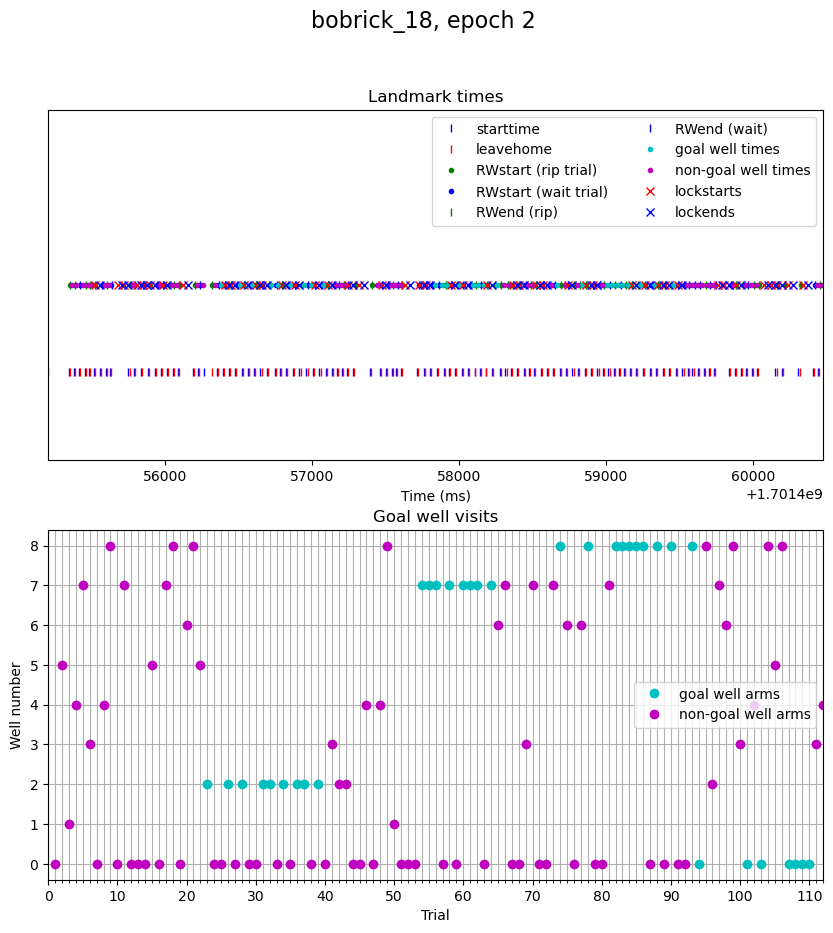

In [18]:
# optional: visualize landmark times during epoch
(TrialInfo & restr).plot_trials()

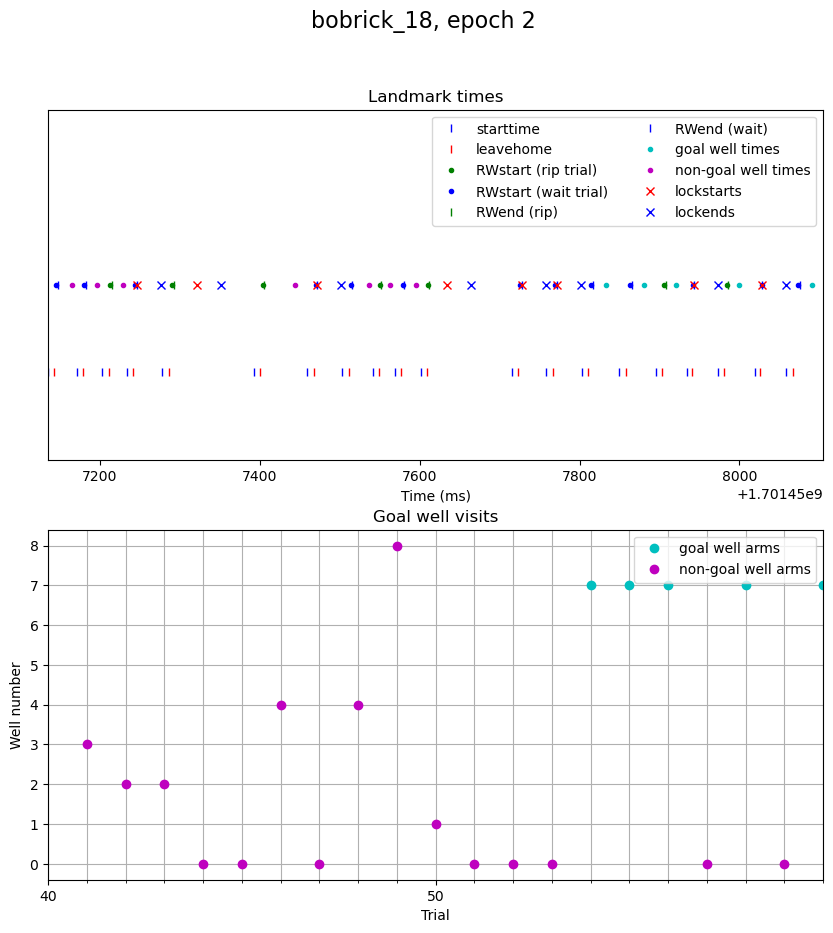

In [19]:
# alternatively, select a smaller interval of trials
(TrialInfo & restr).plot_trials(start=40, end=60)

### Sample analysis: calculating moving reward rates

Helper methods `get_goal_fractions` and `plot_goal_fractions` to visualize reward rate aligned to the most recent goal-change/reward trial

(ref https://www.sciencedirect.com/science/article/pii/S0896627321005730#fig1)

In [20]:
sys.path.append("..")
from utils.data_vis import plot_goal_fractions, get_goal_fractions

In [21]:
# processed data returned as dictionary of arrays; may be helpful for aggregating data from multiple epochs
data = get_goal_fractions(df)
data

{'goal_fraction_since_change': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.04347826, 0.04166667, 0.04      ,
        0.07692308, 0.07407407, 0.10714286, 0.10344828, 0.1       ,
        0.12903226, 0.15625   , 0.15151515, 0.17647059, 0.17142857,
        0.19444444, 0.21621622, 0.21052632, 0.23076923, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06666667, 0.125     ,
        0.17647059, 0.16666667, 0.21052632, 0.2       , 0.23809524,
        0.27272727, 0.30434783, 0.29166667, 0.32      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        

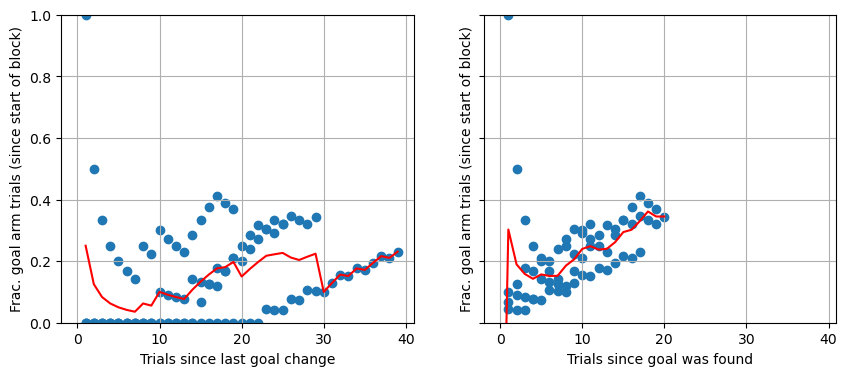

In [22]:
# alternatively, just view plots of single session
plot_goal_fractions(df)

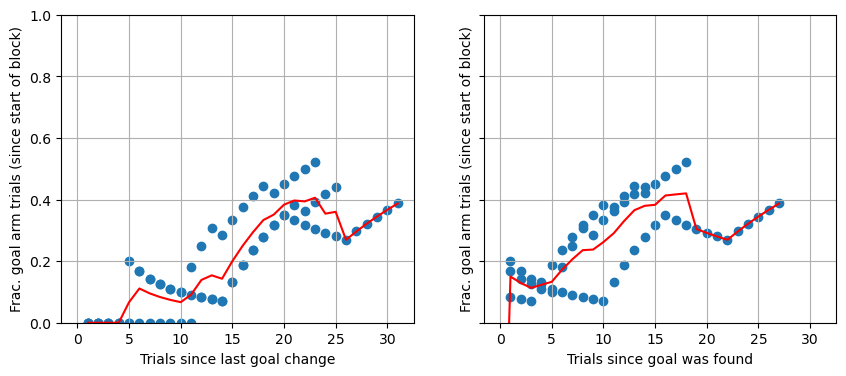

In [23]:
# let's try herman!
df_ep4 = (TrialInfo & {"nwb_file_name": "herman20211114_.nwb", "epoch": 4}).fetch1_dataframe()
plot_goal_fractions(df_ep4)

## Deleting Entries

In [14]:
# Deletes TrialInfo entries from this session
(TrialInfo & {"nwb_file_name" : nwb_file_name}).delete()

[15:46:51][INFO] Spyglass: Building merge cache for __trial_info.
	Found 0 downstream merge tables


[2024-05-22 15:46:51,583][INFO]: Deleting 2 rows from `trial_info`.`__trial_info`
[2024-05-22 15:46:53,661][INFO]: Deletes committed.


In [15]:
TrialInfo & {"nwb_file_name" : nwb_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),dio_event_name the name assigned to this DIO event,analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [6]:
# Automatically deletes AnalysisNwbfile entries that are not referenced a downstream table
# AND removes the filepath entries for NWB files that are not in use.
AnalysisNwbfile.nightly_cleanup()

100%|██████████| 4/4 [00:00<00:00, 93.11it/s]
